# Chapter 10 家用热水器用户行为分析与事件识别

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import joblib
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

In [4]:
inputfile = '../data/chapter10_original_data.xls'  # 输入的数据文件
data = pd.read_excel(inputfile)  # 读取数据
data.head()

,热水器编号,发生时间,开关机状态,加热中,保温中,有无水流,实际温度,热水量,水流量,节能模式,加热剩余时间,当前设置温度
0,R_00001,20141019063917,关,关,关,无,30°C,0%,0,关,0分钟,50°C
1,R_00001,20141019070154,关,关,关,无,30°C,0%,0,关,0分钟,50°C
2,R_00001,20141019070156,关,关,关,无,30°C,0%,8,关,0分钟,50°C
3,R_00001,20141019071230,关,关,关,无,30°C,0%,0,关,0分钟,50°C
4,R_00001,20141019071236,关,关,关,无,29°C,0%,0,关,0分钟,50°C


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21516 (\N{CJK UNIFIED IDEOGRAPH-540C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27700 (\N{CJK UNIFIED IDEOGRAPH-6C34}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27969 (\N{CJK UNIFIED IDE

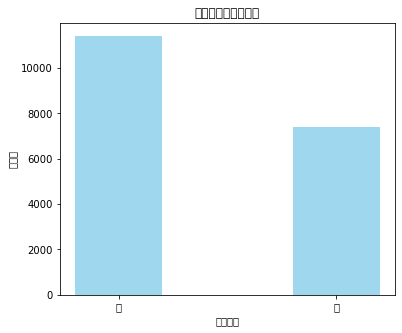

In [6]:
# 查看有无水流的分布
# 数据提取
lv_non = pd.value_counts(data['有无水流'])['无']
lv_move = pd.value_counts(data['有无水流'])['有']

# 绘制条形图
fig = plt.figure(figsize = (6 ,5))  # 设置画布大小
plt.rcParams['font.sans-serif'] = 'SimHei'  # 设置中文显示
plt.rcParams['axes.unicode_minus'] = False
plt.bar(x=range(2), height=[lv_non,lv_move], width=0.4, alpha=0.8,
        color='skyblue')
plt.xticks([index for index in range(2)], ['无','有'])
plt.xlabel('水流状态')
plt.ylabel('记录数')
plt.title('不同水流状态记录数')
plt.show()
plt.close()

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27700 (\N{CJK UNIFIED IDEOGRAPH-6C34}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27969 (\N{CJK UNIFIED IDEOGRAPH-6D41}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: Us

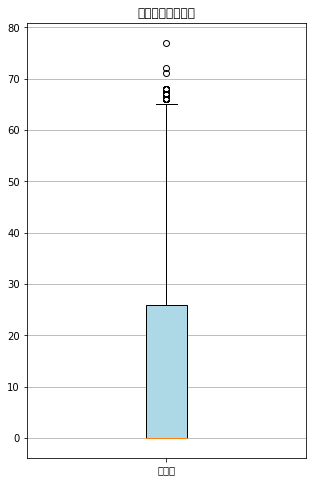

In [7]:
# 查看水流量分布
water = data['水流量']
# 绘制水流量分布箱型图
fig = plt.figure(figsize = (5 ,8))
plt.boxplot(water,
            patch_artist=True,
            labels = ['水流量'],  # 设置x轴标题
            boxprops = {'facecolor':'lightblue'})  # 设置填充颜色
plt.title('水流量分布箱线图')
# 显示y坐标轴的底线
plt.grid(axis='y')
plt.show()

In [9]:
print('初始状态的数据形状为：', data.shape)
# 删除热水器编号、有无水流、节能模式属性
data.drop(labels=["热水器编号","有无水流","节能模式"],axis=1,inplace=True)
print('删除冗余属性后的数据形状为：', data.shape)
data.to_csv('../data/chapter10_water_heart.csv',index=False)

初始状态的数据形状为： (18840, 12)
删除冗余属性后的数据形状为： (18840, 9)


In [10]:
# 划分用水事件
threshold = pd.Timedelta('4 min')  # 阈值为4分钟
data['发生时间'] = pd.to_datetime(data['发生时间'], format = '%Y%m%d%H%M%S')  # 转换时间格式
data = data[data['水流量'] > 0]  # 只要流量大于0的记录
sjKs = data['发生时间'].diff() > threshold  # 相邻时间向前差分，比较是否大于阈值
sjKs.iloc[0] = True  # 令第一个时间为第一个用水事件的开始事件
sjJs = sjKs.iloc[1:]  # 向后差分的结果
sjJs = pd.concat([sjJs,pd.Series(True)])  # 令最后一个时间作为最后一个用水事件的结束时间
# 创建数据框，并定义用水事件序列
sj = pd.DataFrame(np.arange(1,sum(sjKs)+1),columns = ["事件序号"])
sj["事件起始编号"] = data.index[sjKs == 1]+1  # 定义用水事件的起始编号
sj["事件终止编号"] = data.index[sjJs == 1]+1  # 定义用水事件的终止编号
print('当阈值为4分钟的时候事件数目为：',sj.shape[0])
sj.to_csv('../data/chapter10_sj.csv',index = False)

当阈值为4分钟的时候事件数目为： 172


In [11]:
# 确定单次用水事件时长阈值
n = 4  # 使用以后四个点的平均斜率
threshold = pd.Timedelta(minutes=5)  # 专家阈值
data['发生时间'] = pd.to_datetime(data['发生时间'], format='%Y%m%d%H%M%S')
data = data[data['水流量'] > 0]  # 只要流量大于0的记录
# 自定义函数：输入划分时间的时间阈值，得到划分的事件数
def event_num(ts):
    d = data['发生时间'].diff() > ts  # 相邻时间作差分，比较是否大于阈值
    return d.sum() + 1  # 这样直接返回事件数
dt = [pd.Timedelta(minutes=i) for i in np.arange(1, 9, 0.25)]
h = pd.DataFrame(dt, columns=['阈值'])  # 转换数据框，定义阈值列
h['事件数'] = h['阈值'].apply(event_num)  # 计算每个阈值对应的事件数
h['斜率'] = h['事件数'].diff()/0.25  # 计算每两个相邻点对应的斜率
h['斜率指标']= h['斜率'].abs().rolling(4).mean()  # 往前取n个斜率绝对值平均作为斜率指标
ts = h['阈值'][h['斜率指标'].idxmin() - n]
# 用idxmin返回最小值的Index，由于rolling_mean()计算的是前n个斜率的绝对值平均
# 所以结果要进行平移（-n）
if ts > threshold:
    ts = pd.Timedelta(minutes=4)
print('计算出的单次用水时长的阈值为：',ts)

计算出的单次用水时长的阈值为： 0 days 00:04:00


In [12]:
data.head()

,发生时间,开关机状态,加热中,保温中,实际温度,热水量,水流量,加热剩余时间,当前设置温度
2,2014-10-19 07:01:56,关,关,关,30°C,0%,8,0分钟,50°C
56,2014-10-19 07:38:16,关,关,关,30°C,0%,8,0分钟,50°C
381,2014-10-19 09:46:38,关,关,关,29°C,0%,16,0分钟,50°C
382,2014-10-19 09:46:40,关,关,关,29°C,0%,13,0分钟,50°C
384,2014-10-19 09:47:15,关,关,关,29°C,0%,20,0分钟,50°C


In [17]:
data = pd.read_excel('../data/chapter10_water_hearter.xlsx')  # 读取热水器使用数据记录
data.head()

,发生时间,开关机状态,加热中,保温中,实际温度,热水量,水流量,加热剩余时间,当前设置温度
0,20141019063917,关,关,关,30°C,0%,0,0分钟,50°C
1,20141019070154,关,关,关,30°C,0%,0,0分钟,50°C
2,20141019070156,关,关,关,30°C,0%,8,0分钟,50°C
3,20141019071230,关,关,关,30°C,0%,0,0分钟,50°C
4,20141019071236,关,关,关,29°C,0%,0,0分钟,50°C


In [18]:
# 转换时间格式
data["发生时间"] = pd.to_datetime(data["发生时间"],format="%Y%m%d%H%M%S")

# 构造特征：总用水时长
timeDel = pd.Timedelta("0.5 sec")
sj["事件开始时间"] = data.iloc[sj["事件起始编号"]-1,0].values- timeDel
sj["事件结束时间"] = data.iloc[sj["事件终止编号"]-1,0].values + timeDel
sj['洗浴时间点'] = [i.hour for i in sj["事件开始时间"]]
sj["总用水时长"] = np.int64(sj["事件结束时间"] - sj["事件开始时间"])/1000000000 + 1

# 构造用水停顿事件
# 构造特征“停顿开始时间”、“停顿结束时间”
# 停顿开始时间指从有水流到无水流，停顿结束时间指从无水流到有水流
for i in range(len(data)-1):
    if (data.loc[i,"水流量"] != 0) & (data.loc[i + 1,"水流量"] == 0) :
        data.loc[i + 1,"停顿开始时间"] = data.loc[i +1, "发生时间"] - timeDel
    if (data.loc[i,"水流量"] == 0) & (data.loc[i + 1,"水流量"] != 0) :
        data.loc[i,"停顿结束时间"] = data.loc[i , "发生时间"] + timeDel

# 提取停顿开始时间与结束时间所对应行号，放在数据框Stop中
indStopStart = data.index[data["停顿开始时间"].notnull()]+1
indStopEnd = data.index[data["停顿结束时间"].notnull()]+1
Stop = pd.DataFrame(data={"停顿开始编号":indStopStart[:-1],
                            "停顿结束编号":indStopEnd[1:]})
# 计算停顿时长，并放在数据框stop中，停顿时长=停顿结束时间-停顿结束时间
Stop["停顿时长"] = np.int64(data.loc[indStopEnd[1:]-1,"停顿结束时间"].values-
                     data.loc[indStopStart[:-1]-1,"停顿开始时间"].values)/1000000000
# 将每次停顿与事件匹配,停顿的开始时间要大于事件的开始时间，
# 且停顿的结束时间要小于事件的结束时间
for i in range(len(sj)):
    Stop.loc[(Stop["停顿开始编号"] > sj.loc[i,"事件起始编号"]) &
           (Stop["停顿结束编号"] < sj.loc[i,"事件终止编号"]),"停顿归属事件"]=i+1

# 删除停顿次数为0的事件
Stop = Stop[Stop["停顿归属事件"].notnull()]

# 构造特征 用水事件停顿总时长、停顿次数、停顿平均时长、
# 用水时长，用水/总时长
stopAgg =  Stop.groupby("停顿归属事件").agg({"停顿时长":sum,"停顿开始编号":len})
sj.loc[stopAgg.index - 1,"总停顿时长"] = stopAgg.loc[:,"停顿时长"].values
sj.loc[stopAgg.index-1,"停顿次数"] = stopAgg.loc[:,"停顿开始编号"].values
sj.fillna(0,inplace=True)  # 对缺失值用0插补
stopNo0 = sj["停顿次数"] != 0  # 判断用水事件是否存在停顿
sj.loc[stopNo0,"平均停顿时长"] = sj.loc[stopNo0,"总停顿时长"]/sj.loc[stopNo0,"停顿次数"]
sj.fillna(0,inplace=True)  # 对缺失值用0插补
sj["用水时长"] = sj["总用水时长"] - sj["总停顿时长"]  # 定义特征用水时长
sj["用水/总时长"] = sj["用水时长"] / sj["总用水时长"]  # 定义特征 用水/总时长
print('用水事件用水时长与频率特征构造完成后数据的特征为：\n',sj.columns)
print('用水事件用水时长与频率特征构造完成后数据的前5行5列特征为：\n',
      sj.iloc[:5,:5])

用水事件用水时长与频率特征构造完成后数据的特征为：
 Index(['事件序号', '事件起始编号', '事件终止编号', '事件开始时间', '事件结束时间', '洗浴时间点', '总用水时长',
       '总停顿时长', '停顿次数', '平均停顿时长', '用水时长', '用水/总时长'],
      dtype='object')
用水事件用水时长与频率特征构造完成后数据的前5行5列特征为：
    事件序号  事件起始编号  事件终止编号                  事件开始时间                  事件结束时间
0     1       3       3 2014-10-19 07:01:55.500 2014-10-19 07:01:56.500
1     2      57      57 2014-10-19 07:38:15.500 2014-10-19 07:38:16.500
2     3     382     385 2014-10-19 09:46:37.500 2014-10-19 09:47:15.500
3     4     405     405 2014-10-19 11:50:16.500 2014-10-19 11:50:17.500
4     5     408     408 2014-10-19 13:56:20.500 2014-10-19 13:56:21.500


In [19]:
data["水流量"] = data["水流量"] / 60 # 原单位L/min，现转换为L/sec
sj["总用水量"] = 0 # 给总用水量赋一个初始值0
for i in range(len(sj)):
    Start = sj.loc[i,"事件起始编号"]-1
    End = sj.loc[i,"事件终止编号"]-1
    if Start != End:
        for j in range(Start,End):
            if data.loc[j,"水流量"] != 0:
                sj.loc[i,"总用水量"] = (data.loc[j + 1,"发生时间"] -
                                    data.loc[j,"发生时间"]).seconds* \
                                    data.loc[j,"水流量"] + sj.loc[i,"总用水量"]
        sj.loc[i,"总用水量"] = sj.loc[i,"总用水量"] + data.loc[End,"水流量"] * 2
    else:
        sj.loc[i,"总用水量"] = data.loc[Start,"水流量"] * 2

sj["平均水流量"] = sj["总用水量"] / sj["用水时长"] # 定义特征 平均水流量
# 构造特征：水流量波动
# 水流量波动=∑(((单次水流的值-平均水流量)^2)*持续时间)/用水时长
sj["水流量波动"] = 0 # 给水流量波动赋一个初始值0
for i in range(len(sj)):
    Start = sj.loc[i,"事件起始编号"] - 1
    End = sj.loc[i,"事件终止编号"] - 1
    for j in range(Start,End + 1):
        if data.loc[j,"水流量"] != 0:
            slbd = (data.loc[j,"水流量"] - sj.loc[i,"平均水流量"])**2
            slsj = (data.loc[j + 1,"发生时间"] - data.loc[j,"发生时间"]).seconds
            sj.loc[i,"水流量波动"] = slbd * slsj + sj.loc[i,"水流量波动"]
    sj.loc[i,"水流量波动"] = sj.loc[i,"水流量波动"] / sj.loc[i,"用水时长"]

# 构造特征：停顿时长波动
# 停顿时长波动=∑(((单次停顿时长-平均停顿时长)^2)*持续时间)/总停顿时长
sj["停顿时长波动"] = 0 # 给停顿时长波动赋一个初始值0
for i in range(len(sj)):
    if sj.loc[i,"停顿次数"] > 1: # 当停顿次数为0或1时，停顿时长波动值为0，故排除
        for j in Stop.loc[Stop["停顿归属事件"] == (i+1),"停顿时长"].values:
            sj.loc[i,"停顿时长波动"] = ((j - sj.loc[i,"平均停顿时长"])**2) * j + \
                                     sj.loc[i,"停顿时长波动"]
        sj.loc[i,"停顿时长波动"] = sj.loc[i,"停顿时长波动"] / sj.loc[i,"总停顿时长"]

print('用水量和波动特征构造完成后数据的特征为：\n',sj.columns)
print('用水量和波动特征构造完成后数据的前5行5列特征为：\n',sj.iloc[:5,:5])

用水量和波动特征构造完成后数据的特征为：
 Index(['事件序号', '事件起始编号', '事件终止编号', '事件开始时间', '事件结束时间', '洗浴时间点', '总用水时长',
       '总停顿时长', '停顿次数', '平均停顿时长', '用水时长', '用水/总时长', '总用水量', '平均水流量', '水流量波动',
       '停顿时长波动'],
      dtype='object')
用水量和波动特征构造完成后数据的前5行5列特征为：
    事件序号  事件起始编号  事件终止编号                  事件开始时间                  事件结束时间
0     1       3       3 2014-10-19 07:01:55.500 2014-10-19 07:01:56.500
1     2      57      57 2014-10-19 07:38:15.500 2014-10-19 07:38:16.500
2     3     382     385 2014-10-19 09:46:37.500 2014-10-19 09:47:15.500
3     4     405     405 2014-10-19 11:50:16.500 2014-10-19 11:50:17.500
4     5     408     408 2014-10-19 13:56:20.500 2014-10-19 13:56:21.500


In [21]:
sj_bool = (sj['用水时长'] >100) & (sj['总用水时长'] > 120) & (sj['总用水量'] > 5)
sj_final = sj.loc[sj_bool,:]
sj_final.to_excel('../data/chapter10_sj_final.xlsx',index=False)
print('筛选出候选洗浴事件前的数据形状为：',sj.shape)
print('筛选出候选洗浴事件后的数据形状为：',sj_final.shape)

筛选出候选洗浴事件前的数据形状为： (172, 16)
筛选出候选洗浴事件后的数据形状为： (75, 16)


In [25]:
# 读取数据
Xtrain = pd.read_excel('../data/chapter10_sj_final.xlsx')
ytrain = pd.read_excel('../data/chapter10_water_heater_log.xlsx')
test = pd.read_excel('../data/chapter10_test_data.xlsx')
# 训练集测试集区分。
x_train, x_test, y_train, y_test = Xtrain.iloc[:,5:],test.iloc[:,4:-1],\
                                   ytrain.iloc[:,-1],test.iloc[:,-1]
# 标准化
stdScaler = StandardScaler().fit(x_train)
x_stdtrain = stdScaler.transform(x_train)
x_stdtest = stdScaler.transform(x_test)
# 建立模型
bpnn = MLPClassifier(hidden_layer_sizes = (17,10), max_iter = 200, solver = 'lbfgs',random_state=50)
bpnn.fit(x_stdtrain, y_train)
# 保存模型
joblib.dump(bpnn,'../data/chapter10_water_heater_nnet.m')
print('构建的模型为：\n',bpnn)

构建的模型为：
 MLPClassifier(hidden_layer_sizes=(17, 10), random_state=50, solver='lbfgs')


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


神经网络预测结果评价报告：
               precision    recall  f1-score   support

           0       0.47      0.75      0.58        12
           1       0.90      0.73      0.81        37

    accuracy                           0.73        49
   macro avg       0.69      0.74      0.69        49
weighted avg       0.80      0.73      0.75        49



/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25143 (\N{CJK UNIFIED IDEOGRAPH-6237}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27700 (\N{CJK UNIFIED IDEOGRAPH-6C34}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20107 (\N{CJK UNIFIED IDEOGRAPH-4E8B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: Us

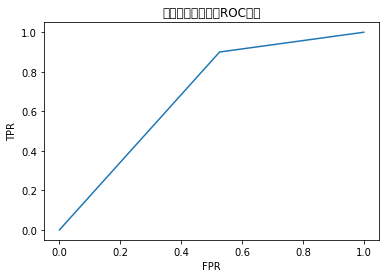

In [27]:
y_pred = bpnn.predict(x_stdtest)  # 返回预测结果
print('神经网络预测结果评价报告：\n',classification_report(y_test,y_pred))
# 绘制roc曲线图
plt.rcParams['font.sans-serif'] = 'SimHei'  # 显示中文
plt.rcParams['axes.unicode_minus'] = False  # 显示负号
fpr, tpr, thresholds = roc_curve(y_pred,y_test)  # 求出TPR和FPR
plt.figure(figsize=(6,4))  # 创建画布
plt.plot(fpr,tpr)  # 绘制曲线
plt.title('用户用水事件识别ROC曲线')  # 标题
plt.xlabel('FPR')  # x轴标签
plt.ylabel('TPR')  # y轴标签
plt.show()  # 显示图形